# VLM GROUNDER

## Task
Input:
- Query (grounding prompt)
- Scene (images, depths, poses)

Output:
- 3D Instance segmentation
- 2D Instance segmentation

## Method
![img](https://github.com/OpenRobotLab/VLM-Grounder/raw/main/assets/method.jpg)

### Zero-shot grounding
<span style="color: #009900; font-weight: bold;">We don't need to train any model for this task.</span>

### Imports

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
import torch
from pathlib import Path
import json
import requests
import cv2
import pandas as pd


### Process paths

In [56]:
def load_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

path_to_repo = '.'
path_to_repo = Path(path_to_repo)
data_path = path_to_repo / 'data' / 'scannet'

path_to_outputs = path_to_repo / 'outputs'
path_to_cache = path_to_outputs / 'global_cache'

path_to_gdino_cache = path_to_cache / 'gdino_cache'
path_to_detections = path_to_outputs / 'image_instance_detector' / 'Grounding-DINO-1_scanrefer_test_top250_pred_target_classes/chunk-1' / 'detection.pkl'

path_to_dataset = data_path / 'grounding' / 'scanrefer' / 'ScanRefer_filtered_val.json'
val_dataset = load_json(path_to_dataset)

### VAL Dataset

In [ ]:
len(val_dataset)
val_df = pd.DataFrame(val_dataset)
val_df

scene_id object_id       object_name ann_id   
0     scene0011_00         5             chair      3  \
1     scene0011_00        13             chair      3   
2     scene0011_00         9             chair      4   
3     scene0011_00         1  kitchen_cabinets      0   
4     scene0011_00        18                tv      3   
...            ...       ...               ...    ...   
9503  scene0704_00         1              cart      3   
9504  scene0704_00        15          cabinets      1   
9505  scene0704_00        10           picture      2   
9506  scene0704_00        18         trash_can      4   
9507  scene0704_00        10           picture      1   

                                            description   
0     there is a dark brown wooden and leather chair...  \
1     there is a brown wooden chair. placed beside o...   
2     there is a dark brown chair. brown leather and...   
3     there are brwon wooden cabinets. placed on the...   
4     there is a black square tv. placed on the wall...   
...                                                 ...   
9503  this cart is in the center. it is light on its...   
9504  these cabinets are in the corner. they are bro...   
9505  this picture is on the wall. it is in between ...   
9506  this black trash can is in the center. it is e...   
9507  this is the second picture on the wall. it has...   

                                                  token  
0     [there, is, a, dark, brown, wooden, and, leath...  
1     [there, is, a, brown, wooden, chair, ., placed...  
2     [there, is, a, dark, brown, chair, ., brown, l...  
3     [there, are, brwon, wooden, cabinets, ., place...  
4     [there, is, a, black, square, tv, ., placed, o...  
...                                                 ...  
9503  [this, cart, is, in, the, center, ., it, is, l...  
9504  [these, cabinets, are, in, the, corner, ., the...  
9505  [this, picture, is, on, the, wall, ., it, is, ...  
9506  [this, black, trash, can, is, in, the, center,...  
9507  [this, is, the, second, picture, on, the, wall...  

[9508 rows x 6 columns]

In [223]:
val_df.sample(1).values

array([['scene0494_00', '12', 'trash_can', '4',
        'this is a brown trash can on the floor in an office.  it is across from the table by the door.',
        list(['this', 'is', 'a', 'brown', 'trash', 'can', 'on', 'the', 'floor', 'in', 'an', 'office', '.', 'it', 'is', 'across', 'from', 'the', 'table', 'by', 'the', 'door', '.'])]],
      dtype=object)

`scene_id` - ID of the scene

`object_id` - ID of the object (according to the ScanNet dataset)

`object_name` - name of the object

`ann_id` - ID of the annotation(according to the ScanNet dataset)

`description` - description of the object

`token` - tokenized description of the object

### Used validation dataset

<span style="font-size: 1.3em;">ChatGPT costs <span style="color: #009900; font-weight: bold;">$$$</span> so authors used a subset (250 samples) of the validation dataset.</span>

### Query analysis

In [156]:

path_to_query = path_to_outputs / 'query_analysis' / 'scanrefer_250.csv'
df_q = pd.read_csv(path_to_query)
scene_id = 'scene0025_00'

In [160]:
[print(a) for a in df_q[df_q['scan_id'] == scene_id].iloc[1].values]

scene0025_00
34
keyboard
this is a white keyboard. it is located below the computer screen on the right.
['this', 'is', 'a', 'white', 'keyboard', '.', 'it', 'is', 'located', 'below', 'the', 'computer', 'screen', 'on', 'the', 'right', '.']
False
others
False
keyboard
True
1
True
{'right'}
keyboard
["it's white"]
["it's located below the computer screen on the right"]
['00000', '00001', '00002', '00003', '00004', '00005', '00010', '00024', '00025', '00028', '00029', '00030', '00035', '00038', '00046', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00078', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00094', '00095', '00096', '00097']
['00000', '00001', '00002', '00003', '00004', '00005', '00024', '00025', '00028', '00029', '00030', '00038', '00048', '00049', '00050', '00051', '00052', '00053',

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<style>
.chat-container {
    display: flex;
    flex-direction: column;
    width: 100%;
    max-width: 37.5em; /* 600px примерно равно 37.5em при базовом размере шрифта 16px */
    margin: 0 auto;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    box-shadow: 0 0 0.625em rgba(0, 0, 0, 0.1); /* 10px примерно равно 0.625em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    background-color: #f9f9f9;
}

.message {
    align-self: flex-start;
    background-color: #ddeedd;
    color: #000;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    margin: 0.3125em 0; /* 5px примерно равно 0.3125em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    max-width: 80%;
    word-wrap: break-word;
}

.response {
    align-self: flex-end;
    background-color: #eeeeff;
    color: #000;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    margin: 0.3125em 0; /* 5px примерно равно 0.3125em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    max-width: 80%;
    word-wrap: break-word;
}

.system {
    color: #000099;
}
</style>
<div class="chat-container">
    <div class="message">
        <span class="system">------SYSTEM_PROMPT------</span>
        <br>
        <span>You are working on a 3D visual grounding task, which involves receiving a query that specifies a particular object by describing its attributes and grounding conditions to uniquely identify the object. Here, attributes refer to the inherent properties of the object, such as category, color, appearance, function, etc. Grounding conditions refer to considerations of other objects or other conditions in the scene, such as location, relative position to other objects, etc.
Now, I need you to first parse this query, return the category of the object to be found, and list each of the object's attributes and grounding conditions. Each attribute and condition should be returned individually. Sometimes the object's category is not explicitly specified, and you need to deduce it through reasoning. If you cannot deduce after reasoning, you can use 'unknown' for the category.
Your response should be formatted using JSON contained in ```json```.

Here are some examples:

Input:
Query: this is a brown cabinet. it is to the right of a picture.

Output:
```
{
"target_class": "cabinet",
"attributes": ["it's brown"],
"conditions": ["it's to the right of a picture"]
}
```

Input:
Query: it is a wooden computer desk. the desk is in the sleeping area, across from the living room. the desk is in the corner of the room, between the nightstand and where the shelf and window are.

Output:
```
{
"target_class": "desk",
"attributes": ["it's a wooden computer desk"],
"conditions": ["it's in the sleeping area", "it's across from the living room", "it's in the corner of the room", "it's between the nightstand and where the shelf and window are"]
}
```

Input:
Query: In the room is a set of desks along a wall with windows totaling 4 desks. Opposite this wall is another wall with a door and two desks. The desk of interest is the closest desk to the door. This desk has nothing on it, no monitor, etc.

Output:
```
{
"target_class": "desk",
"attributes": [],  # no attributes
"conditions": ["it's near the wall with a door and two desks, opposite a wall with windows totaling four desks", "it's closest to the door on the wall", "it has nothing on it, no monitor, etc"] # need some reasoning to write the conditions
}
```
Ensure your response adheres strictly to this JSON format, as it will be directly parsed and used.</span>
<br>
<span class="system">------END_SYSTEM_PROMPT------</span>


<span style="font-size: 1.3em; font-weight: bold;">this is a white keyboard. it is located below the computer screen on the right.</span>
</span>
    </div>
    <div class="response">
        <span>{
"target_class": "keyboard",
"attributes": ["it's white"],
"conditions": ["it's located below the computer screen on the right"]
}
</span>
    </div>
</div>

### Query analysis results

Now we have a simple description (label) of the object to be found, and it's attributes and conditions. First, we need to find all objects with this label in the scene.

### Grounding-DINO

Open vocabulary 2d detection model will help us to find all objects with this label in the scene.



![img](https://github.com/IDEA-Research/GroundingDINO/raw/main/.asset/model_explan1.PNG)

Let's find all objects with this label(`keayboard`) in the scene. We apply grounding dino to all images in the scene.

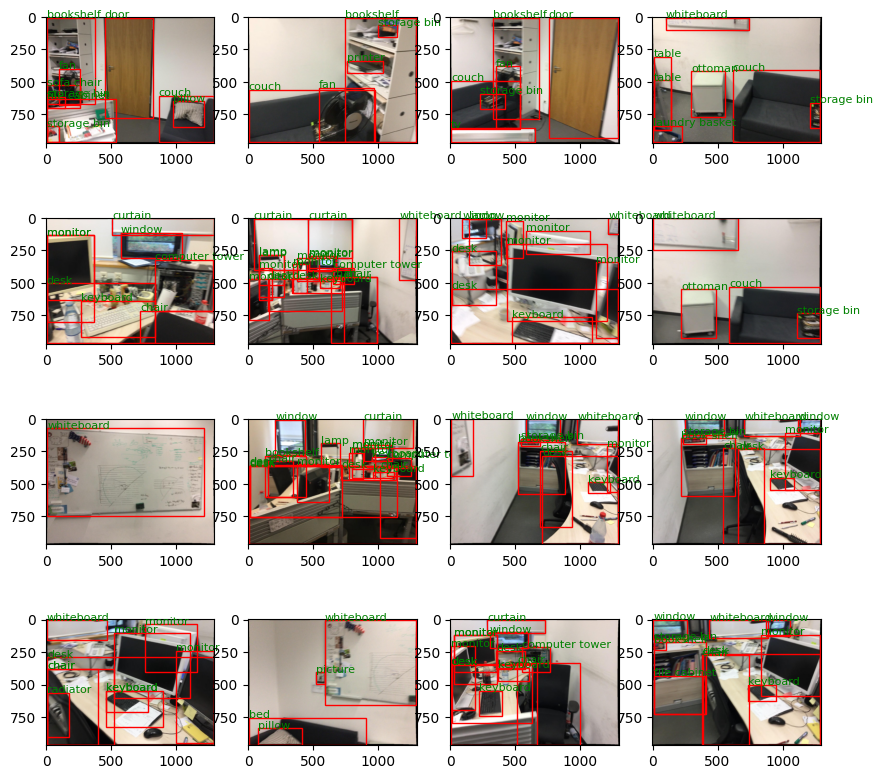

In [161]:
detections = load_pkl(path_to_detections)
keys = detections[scene_id].keys()

hw = 4
items = np.random.choice(list(keys), size=hw*hw, replace=False)
fix, ax = plt.subplots(hw, hw, figsize=(10, 10))
for i, (image) in enumerate(items):
    dets = detections[scene_id][image]
    found_classes = dets.data['class_name']
    img = plt.imread(image)
    ax[i // hw, i % hw].imshow(img)
    # draw bounding boxes
    for k, det in enumerate(dets.xyxy):
        ax[i // hw, i % hw].add_patch(plt.Rectangle((det[0], det[1]), det[2] - det[0], det[3] - det[1], fill=False, color='red', linewidth=1))
        ax[i // hw, i % hw].text(det[0], det[1], dets.data['class_name'][k], color='green', fontsize=8)
        
    
    

### Get Image grids

In [162]:
path_to_out_scene = path_to_outputs / 'visual_grounding/2024-06-21_test_new1/intermediate_results' / scene_id

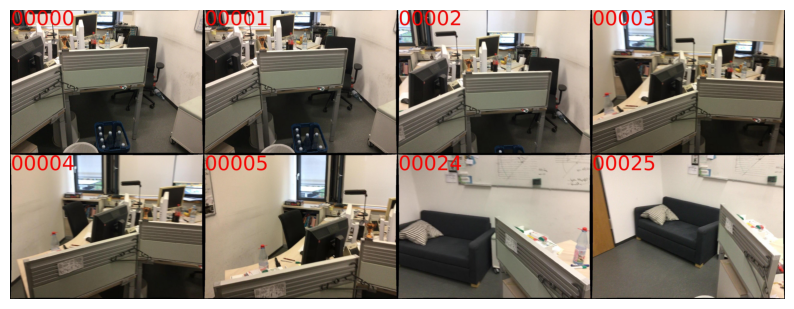

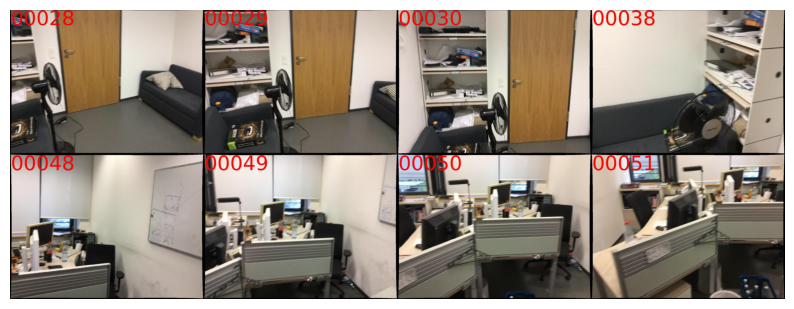

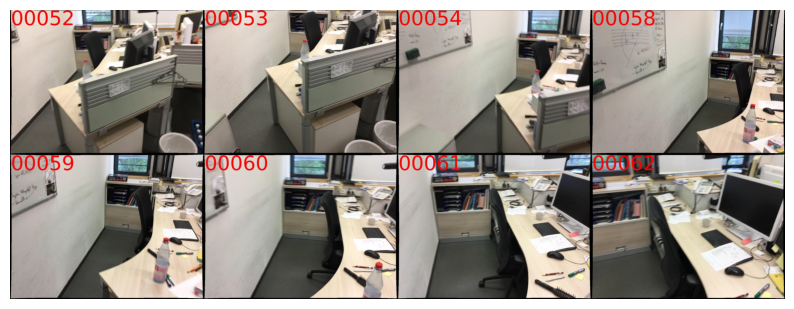

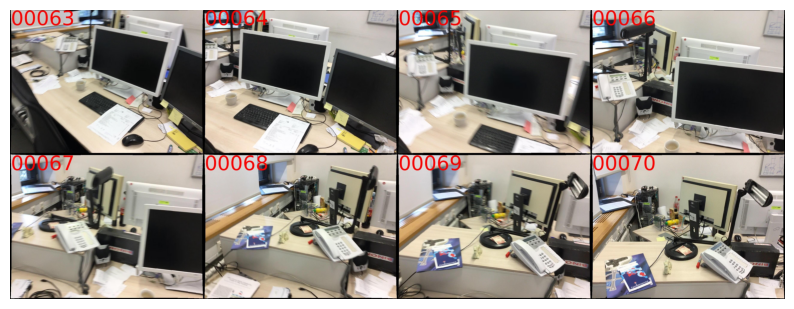

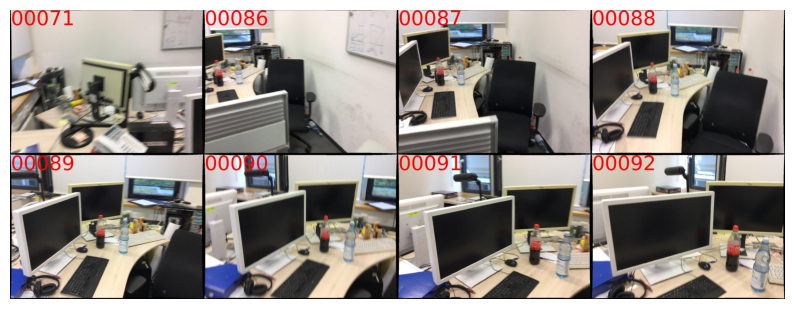

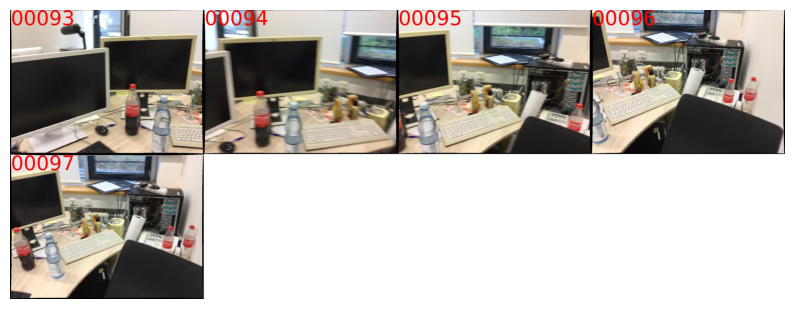

In [164]:
path_to_grids = path_to_out_scene / 'this_is_a_white_keyboard._it_is_located_below_the_computer_s' / 'grid_images'
grid_images = path_to_grids.glob('*.jpg')
grid_images = list(grid_images)
for i, image in enumerate(grid_images):
    img = plt.imread(image)
    plt.subplots(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Select target and reference images

<style>
.chat-container {
    display: flex;
    flex-direction: column;
    width: 100%;
    max-width: 37.5em; /* 600px примерно равно 37.5em при базовом размере шрифта 16px */
    margin: 0 auto;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    box-shadow: 0 0 0.625em rgba(0, 0, 0, 0.1); /* 10px примерно равно 0.625em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    background-color: #f9f9f9;
}

.message {
    align-self: flex-start;
    background-color: #ddeedd;
    color: #000;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    margin: 0.3125em 0; /* 5px примерно равно 0.3125em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    max-width: 80%;
    word-wrap: break-word;
}

.response {
    align-self: flex-end;
    background-color: #eeeeff;
    color: #000;
    padding: 0.625em; /* 10px примерно равно 0.625em */
    margin: 0.3125em 0; /* 5px примерно равно 0.3125em */
    border-radius: 0.5em; /* 8px примерно равно 0.5em */
    max-width: 80%;
    word-wrap: break-word;
}
.system {
    color: #000099;
}
</style>
<div class="chat-container">
    <div class="message">
        <span class="system">------IMAGES------</span>
        <br>
        <span>[IMG1, IMG2, IMG3, ...]</span>
        <br>
        <span class="system">------IMAGES------</span>
        <br>
        <span class="system">------SYSTEM_PROMPT------</span>
        <br>
        <span>You are good at finding objects specified by user queries in indoor rooms by watching the videos scanning the rooms.</span>
        <br>
        <span class="system">------END_SYSTEM_PROMPT------</span>
        <br>
        <span style="font-size: font-weight: bold;"> Imagine you are in a room and are asked to find one object.

Given a series of images from a video scanning an indoor room and a query describing a specific object in the room, you need to analyze the images to locate the object mentioned in the query within the images.

You will be provided with multiple images, and the top-left corner of each image will have an ID indicating the order in which it appears in the video. Adjacent images have adjacent IDs. Please note that to save space, multiple images have been combined into one image with dynamic layouts. You will also be provided with a query sentence describing the object that needs to be found, as well as a parsed version of this query describing the target class of the object to be found and the conditions that this object must satisfy. Please find the ID of the image containing this object based on these conditions. Note that I have filtered the video to remove some images that do not contain objects of the target class. To locate the target object, you need to consider multiple images from different perspectives and determine which image contains the object that meets the conditions. Note, that each condition might not be judged based on just one image alone. Also, the conditions may not be accurate, so it's reasonable for the correct object not to meet all the conditions. You need to find the most possible object based on the query. If you think multiple objects are correct, simply return the one you are most confident of. If you think no objects are meeting the conditions, make a guess to avoid returning nothing. Usually the correct object is visible in multiple images, and you should return the image in which the object is most clearly observed.

Your response should be formatted as a JSON object with three keys "reasoning", "target_image_id", and "reference_image_ids" like this:

{
  "reasoning": "your reasoning process" // Explain the process of how you identified and located the target object. If reasoning across different images is needed, explain which images were used and how you reasoned with them.
  "target_image_id": "00001", // Replace with the actual image ID (only one ID) annotated on the image that contains the target object.
  "reference_image_ids": ["00001", "00002", ...] // A list of IDs of images that are used to determine wether the conditions are met or not.
}

Here is an good example: 
query: Find the black table that is surrounded by four chairs.
{
  "reasoning": "After carefully examining all the input images, I found image 00003, 00005, and 00021 contain different tables, but only the tables in image 00003 and 00021 are black. Further, I found image 00001, image 00002, image 00003, and image 00004 show four chairs and these chairs surround the black table in image 00003. The chair in image 00005 does not meet this condition. So the correct object is the table in image 00003",
  "target_image_id": "00003",
  "reference_image_ids": ["00001", "00002", "00003", "00004"]
}

Now start the task:
Query: "this is a white keyboard. it is located below the computer screen on the right."
Target Class: keyboard
Conditions: ["it's white", "it's located below the computer screen on the right"]

Here are the 45 images for your reference. </span>
</span>
    </div>
    <div class="response">
        <span>"target_image_id": "00095",
  "reference_image_ids": ["00093", "00094", "00095", "00096", "00097"]
</span>
    </div>
</div>


Target image ID: `00095`

In [199]:
target_image = '00095'
gdino_cache = path_to_cache / 'gdino_cache' / scene_id / target_image / 'keyboard.pkl'
target_dets = load_pkl(gdino_cache)
target_dets


Detections(xyxy=array([[269.69506836, 638.67913818, 835.88708496, 917.33215332]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.8829096]), class_id=array([0]), tracker_id=None, data={'class_name': array(['keyboard'], dtype='<U8')})

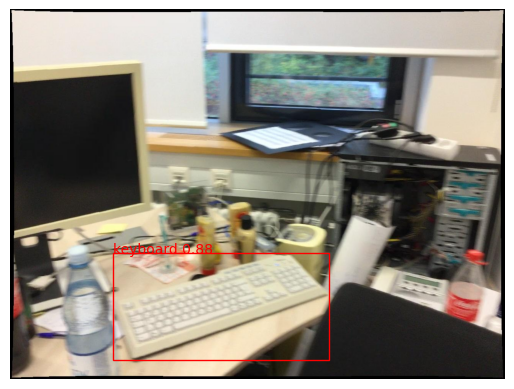

In [202]:
target_image_path = data_path / 'posed_images' / scene_id / (target_image + '.jpg')
target_image = plt.imread(target_image_path)
plt.imshow(target_image)
plt.axis('off')

dets = target_dets
confs = np.round(dets.confidence, 2)
for k, det in enumerate(dets.xyxy):
    plt.gca().add_patch(plt.Rectangle((det[0], det[1]), det[2] - det[0], det[3] - det[1], fill=False, color='red', linewidth=1))
    plt.gca().text(det[0], det[1], dets.data['class_name'][k] + ' ' + str(confs[k]), color='red', fontsize=10)
plt.show()


<span style="color: #ff6666; font-weight: bold;">Another possible case: several detections with same class name. then we need to send image with labeled bboxes to ChatGPT and special prompt. 
<br>
This case will be covered in homework.
</span>

Reference Images:
`["00093", "00094", "00095", "00096", "00097"]`

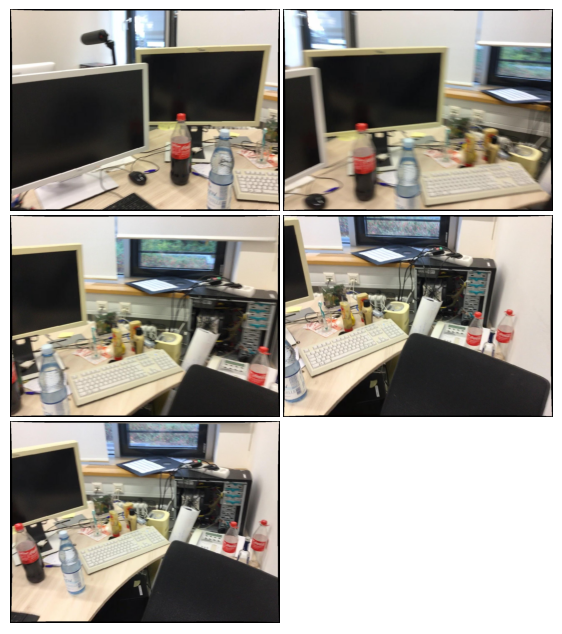

In [180]:
reference_image_ids = ["00093", "00094", "00095", "00096", "00097"]
fig, ax = plt.subplots(3, 2, figsize=(7, 8))
# no distance between images
fig.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(3): 
    for j in range(2): ax[i, j].axis('off')
for k, img in enumerate(reference_image_ids):
    i, j = divmod(k, 2)  # Используем divmod для корректного вычисления индексов
    ax[i, j].imshow(plt.imread(data_path / 'posed_images' / scene_id / f'{img}.jpg'))
    
plt.show()



### Apply SAMv2 to target image with bbox

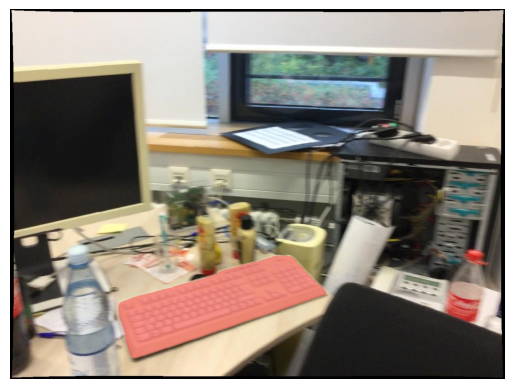

In [ ]:
path_to_segmentations = path_to_out_scene / 'this_is_a_white_keyboard._it_is_located_below_the_computer_s' / 'sam_mask_00095_keyboard_target_34'
segmented_image = plt.imread(path_to_segmentations / 'anchor_sam_raw.jpg')
plt.imshow(segmented_image)
plt.axis('off')
plt.show()

### Match mask to reference images

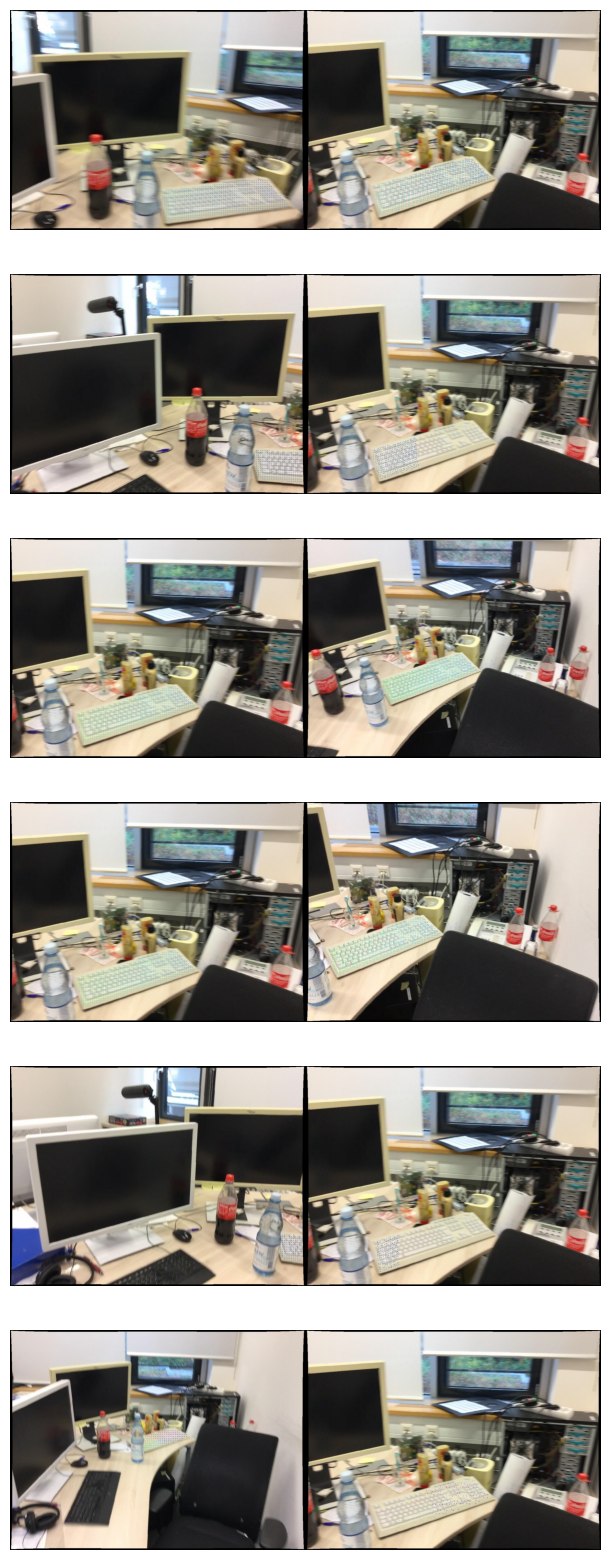

In [212]:
path_to_matches = path_to_segmentations / 'ensemble7' / 'image_matching'
matches = path_to_matches.glob('*.jpg')
matches = list(matches)
fig, ax = plt.subplots(len(matches), 1, figsize=(10, 20))
for i, match in enumerate(matches):
    ax[i].imshow(plt.imread(match))
    ax[i].axis('off')
plt.show()



### Getting bbox and apply SAM

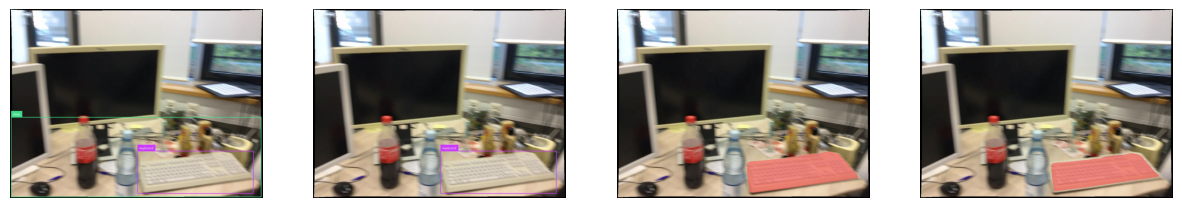

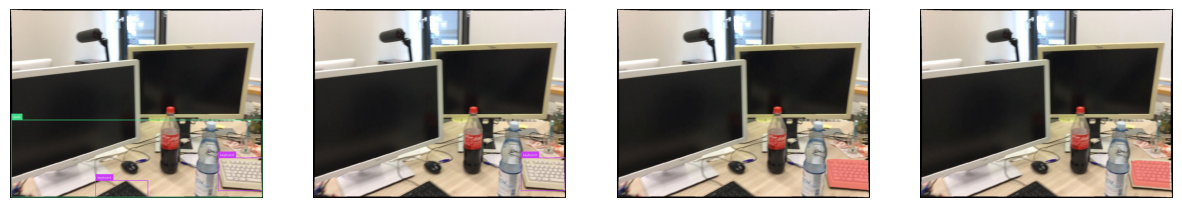

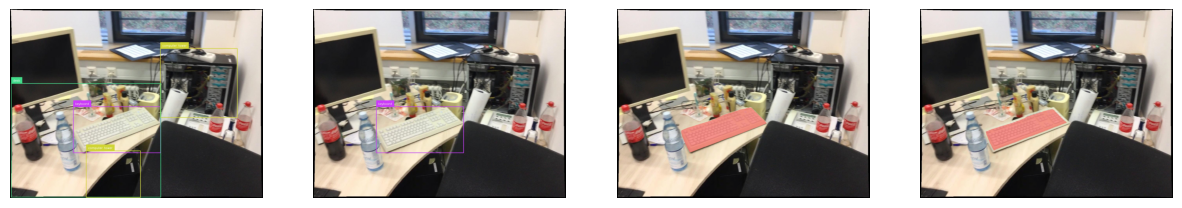

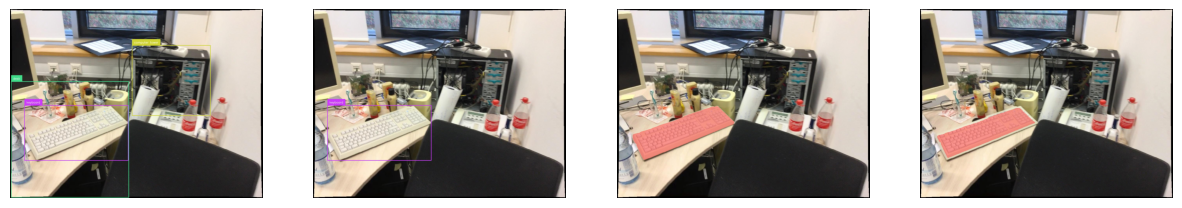

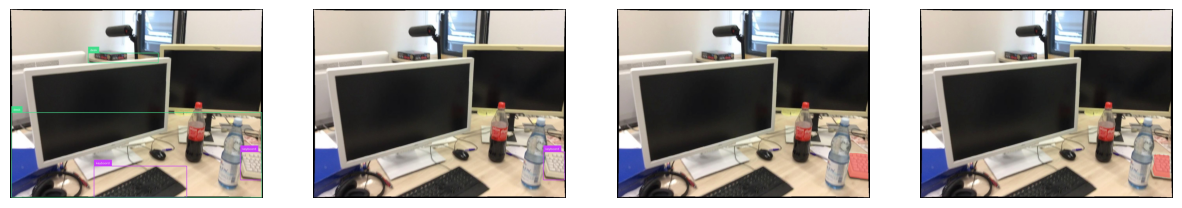

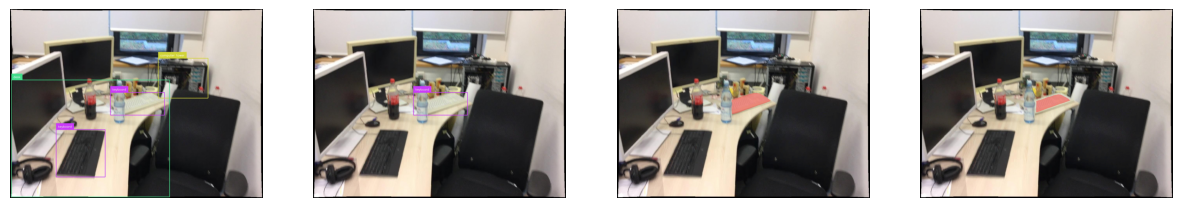

In [220]:
path_to_tracking = path_to_segmentations / 'ensemble7' / 'tracking'
imgs = [*path_to_tracking.glob('*.jpg')]
all_bboxes, bbox, sam, sam_processed = 0, 1, 2, 3
all_bboxes, bbox, sam, sam_processed = imgs[all_bboxes::4], imgs[bbox::4], imgs[sam::4], imgs[sam_processed::4]
for k in range(len(all_bboxes)):
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    for i, im in enumerate([all_bboxes, bbox, sam, sam_processed]):
        ax[i].imshow(plt.imread(im[k]))
        ax[i].axis('off')
    plt.show()


### Project masks to 3D

1) get poses
2) get depths
3) get masks
4) project masks to 3D
5) get 3D bbox
6) get 3D mask
